# Import Packages

In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import plotly.express as px
from configuration.config import DATA_PATH

In [3]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

## Tracking Scoring Metrics for Models

In [4]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
   
    global y_pred

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f'R2 Score: {r2_test}, Root Mean Squared Error: {rmse_test}, Mean Absolute Error: {mae_test}')
    
    y_pred = y_pred_test
   
    return rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test



In [5]:
model_scores = pd.DataFrame({
                             'model_type':[],
                             'train_test_split':[],
                             'is_pca':[], 
                             'score_rmse_train':[],
                             'score_rmse_test':[],
                             'score_mae_train':[],
                             'score_mae_test':[],
                             'score_r2_train':[],
                             'score_r2_test':[],
                             'cv_mean_r2':[],
                             'cv_std_r2':[],
                             'cv_mean_rmse':[],
                             'cv_std_rmse':[],
                             'cv_mean_mae':[],
                             'cv_std_mae':[],
                             'best_params':[] 
                            })
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params


In [6]:
def add_model_score(model_type, train_test_split, is_pca, score_rmse_train, score_rmse_test, score_mae_train, score_mae_test, score_r2_train, score_r2_test, cv_mean_r2, cv_std_r2, cv_mean_rmse, cv_std_rmse, cv_mean_mae, cv_std_mae, best_params=None):
    """
    Adds a row to the model_scores DataFrame with the specified model performance metrics.

    Parameters:
        model_scores (pd.DataFrame): DataFrame to log the results.
        model_type (str): Type of the model.
        train_test_split (str): Description of the data split used.
        is_pca (bool): Indicates if PCA was applied.
        score_rmse (float): Root Mean Squared Error of the model.
        score_mae (float): Mean Absolute Error of the model.
        score_r2 (float): R2 Score of the model.
        cross_val_mean (float): Mean of cross-validation scores.
        cross_val_std (float): Standard deviation of cross-validation scores.
        best_params (dict): Best parameters from model tuning.

    Returns:
        pd.DataFrame: Updated DataFrame with the new model scores.
    """
    global model_scores

    new_row_df = pd.DataFrame([{
        'model_type': model_type,
        'train_test_split': train_test_split,
        'is_pca': is_pca,
        'score_rmse_train': score_rmse_train,
        'score_rmse_test': score_rmse_test,
        'score_mae_train': score_mae_train,
        'score_mae_test': score_mae_test,
        'score_r2_train': score_r2_train,
        'score_r2_test': score_r2_test,
        'cv_mean_r2': cv_mean_r2,
        'cv_std_r2': cv_std_r2,
        'cv_mean_rmse': cv_mean_rmse,
        'cv_std_rmse': cv_std_rmse,
        'cv_mean_mae': cv_mean_mae,
        'cv_std_mae': cv_std_mae,
        'best_params': best_params
    }])

    model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)

In [7]:
# import train/test splits for modeling the reduced and robust scaled data
X_train_rr = pd.read_csv(DATA_PATH + 'modeling/X_train_reduced_robust.csv')
X_test_rr = pd.read_csv(DATA_PATH + 'modeling/X_test_reduced_robust.csv')

# import train/test splits for modeling the reduced and power transformed data
X_train_rp = pd.read_csv(DATA_PATH + 'modeling/X_train_reduced_power.csv')
X_test_rp = pd.read_csv(DATA_PATH + 'modeling/X_test_reduced_power.csv')

# import train/test splits for modeling the imputed and robust scaled data
X_train_ir = pd.read_csv(DATA_PATH + 'modeling/X_train_imputed_robust.csv')
X_test_ir = pd.read_csv(DATA_PATH + 'modeling/X_test_imputed_robust.csv')

# import train/test splits for modeling the imputed and power transformed data
X_train_ip = pd.read_csv(DATA_PATH + 'modeling/X_train_imputed_power.csv')
X_test_ip = pd.read_csv(DATA_PATH + 'modeling/X_test_imputed_power.csv')

y_train = pd.read_csv(DATA_PATH + 'modeling/y_train_data.csv').values.ravel()
y_test = pd.read_csv(DATA_PATH + 'modeling/y_test_data.csv').values.ravel()

y_train_rounded = pd.read_csv(DATA_PATH + 'modeling/y_train_rounded.csv').values.ravel()
y_test_rounded = pd.read_csv(DATA_PATH + 'modeling/y_test_rounded.csv').values.ravel()

# Linear Models

## I. Reduced & Robust Scaled Data


In [8]:
print(X_train_rr.shape, y_train.shape, y_train_rounded.shape)
print(X_test_rr.shape, y_test.shape, y_test_rounded.shape)

(956, 56) (956,) (956,)
(410, 56) (410,) (410,)


### A. Linear Regression

In [9]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.46678825820949416, 0.1297379239538676),
 'neg_mean_squared_error': (-3753793110756.3735, 668577867872.8145),
 'neg_mean_absolute_error': (-1211021.3862532384, 75868.3837732394)}

#### Model Training and Evaluation

R2 Score: 0.5622049771544724, Root Mean Squared Error: 1855705.869085758, Mean Absolute Error: 1215064.037139337


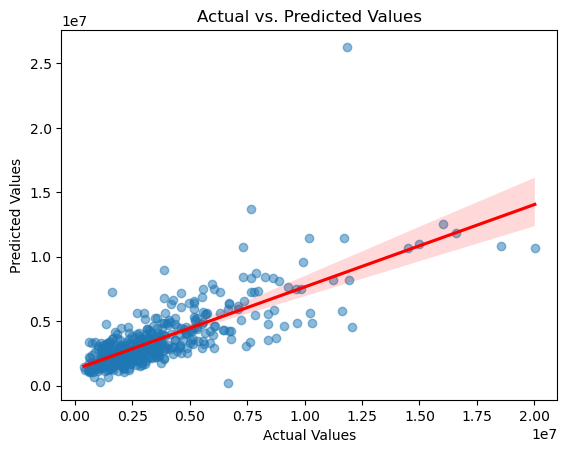

In [10]:
linear_model.fit(X_train_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [11]:
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,0.0,1.475302e+06,1.855706e+06,1.033374e+06,1.215064e+06,0.70537,0.562205,0.466788,0.129738,-3.753793e+12,6.685779e+11,-1.211021e+06,75868.383773,None


### B. Linear Regression with PCA

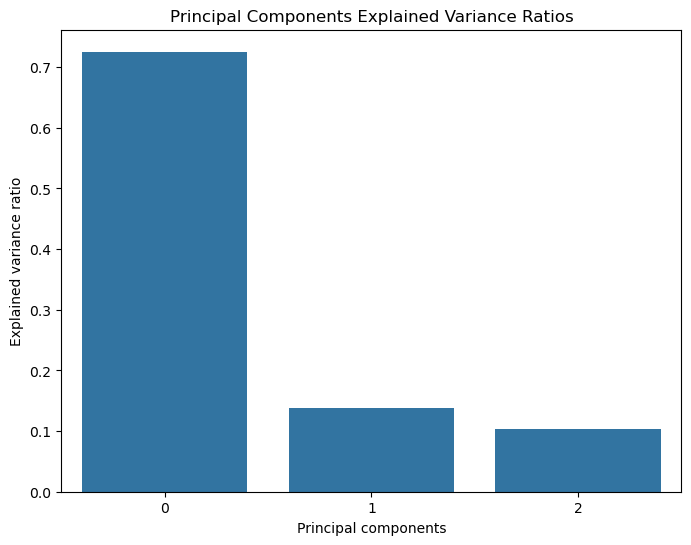

                             PC 1      PC 2      PC 3
public_insurance         0.934287  0.050861 -0.349814
public_insurance_ratio   0.353897 -0.229228  0.905324
migrant_patients         0.032765  0.959969  0.232953
lep_patients             0.010288  0.026486 -0.011893
total_other_revenue      0.009630  0.009480 -0.022798
hispanic_any_race        0.008342  0.037144 -0.006710
uninsured                0.007462  0.016110 -0.009623
homeless_patients        0.006991  0.011960 -0.017407
public_housing_patients  0.006766  0.003686 -0.014437
low_income               0.006454  0.023799 -0.007970
total_grant_funding      0.006145  0.008277 -0.011487
total_patients           0.006095  0.019666 -0.008706
total_18_up              0.006026  0.018968 -0.009410
total_0_17               0.005632  0.019149 -0.006397
fpl_unknown              0.005504  0.008868 -0.010401


In [12]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_rr)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rr)
X_test_pca = pca.transform(X_test_rr)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_rr.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [13]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_train_rr.index)
X_train_pca_rr = pd.concat([X_train_rr, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_test_rr.index)
X_test_pca_rr = pd.concat([X_test_rr, X_test_pca_df], axis=1)

R2 Score: 0.5593513746791512, Root Mean Squared Error: 1861743.9068646326, Mean Absolute Error: 1215428.7365853658


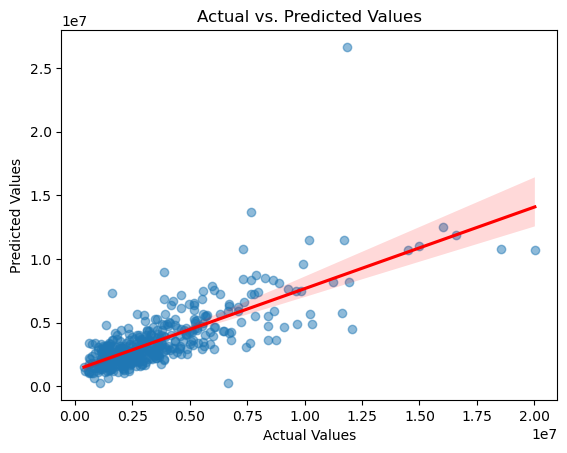

In [14]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

R2 Score: 0.5636488693193802, Root Mean Squared Error: 1851220.317693003, Mean Absolute Error: 1212243.9866895345


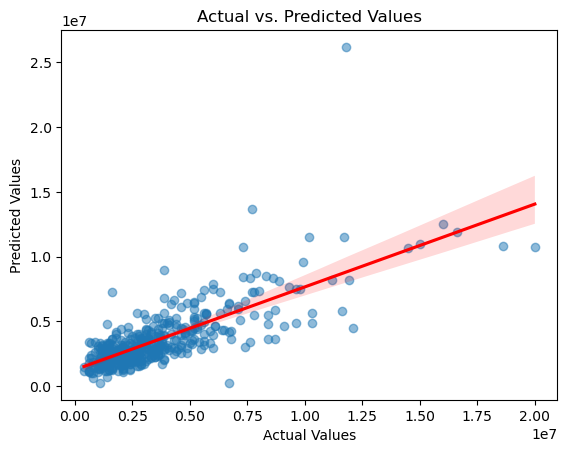

In [15]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_rr, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## II. Reduced & Power Transformed Data

### A. Linear Regression

In [16]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.6009434205011799, 0.06792036129086805),
 'neg_mean_squared_error': (-2882799704530.376, 622508296030.3695),
 'neg_mean_absolute_error': (-1196999.965294556, 99812.60403583517)}

R2 Score: 0.6243908880867663, Root Mean Squared Error: 1718865.0892237304, Mean Absolute Error: 1210823.8048268377


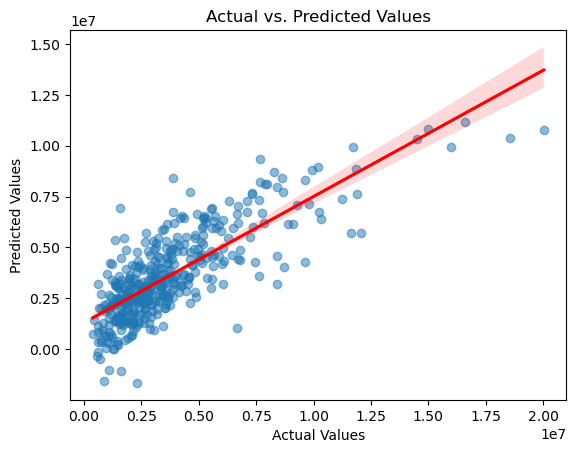

In [17]:
linear_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### B. Linear Regression with PCA

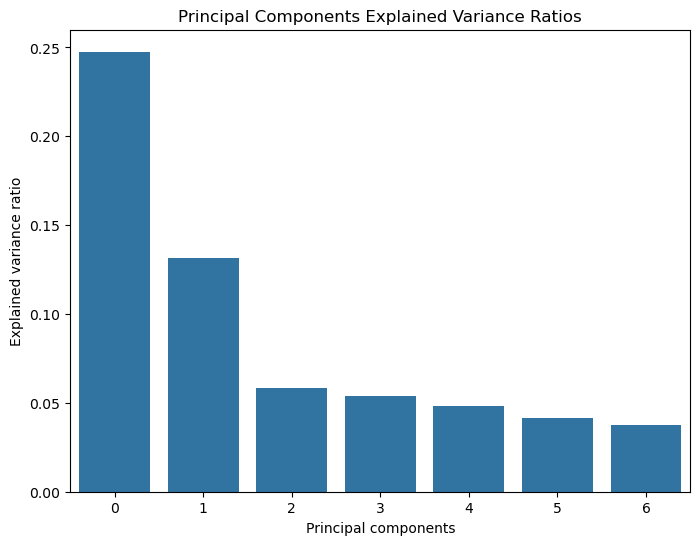

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_patients               0.257850  0.055744  0.013855  0.007612 -0.084560   
total_18_up                  0.254337  0.061983  0.000095  0.032961 -0.056930   
medicaid                     0.244639  0.021617 -0.047036 -0.029873 -0.084450   
low_income                   0.234980 -0.059729  0.001690  0.139155 -0.116830   
total_0_17                   0.233732  0.052094  0.065236 -0.048965 -0.142887   
hispanic_any_race            0.219572 -0.112566  0.163579 -0.067366  0.063660   
total_grant_funding          0.216113 -0.028421 -0.018040 -0.059001 -0.000185   
TotalWeeklyHoursOfOperation  0.213756  0.073979 -0.034728  0.131598 -0.049628   
uninsured                    0.209698 -0.080864  0.106107  0.038547 -0.001250   
lep_patients                 0.205428 -0.147275  0.151312 -0.113416  0.022154   
ZipCode_Count                0.201985  0.017896 -0.040123 -0.010641 -0.085535   
total_sites                 

In [18]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_rp)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rp)
X_test_pca = pca.transform(X_test_rp)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_rp.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [19]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_rp.index)
X_train_pca_rp = pd.concat([X_train_rp, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_rp.index)

X_test_pca_rp = pd.concat([X_test_rp, X_test_pca_df], axis=1)

R2 Score: 0.6162425959489707, Root Mean Squared Error: 1737409.1932157495, Mean Absolute Error: 1220350.927640214


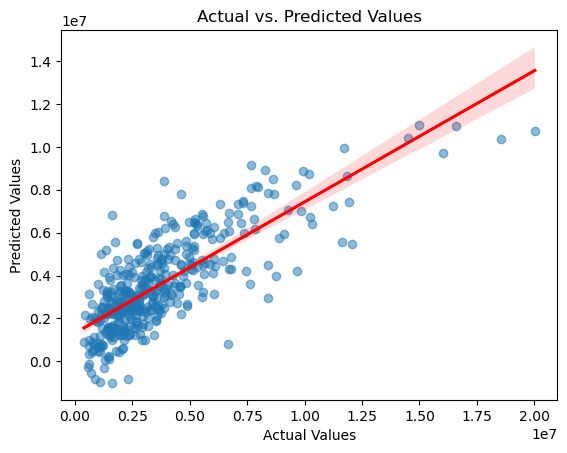

In [20]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rp, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

In [21]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores



{'r2': (0.6007665001069685, 0.06747764963206873),
 'neg_mean_squared_error': (-2886538418904.1533, 622470067822.548),
 'neg_mean_absolute_error': (-1198890.1184100017, 97918.26188576884)}

R2 Score: 0.6245543916612908, Root Mean Squared Error: 1717171.095886256, Mean Absolute Error: 1210512.6130547659


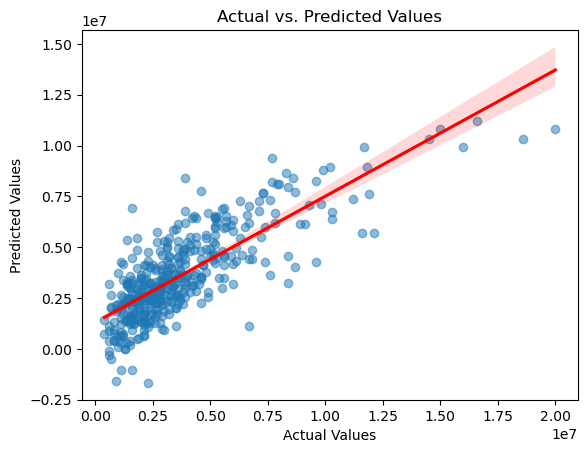

In [22]:
linear_model.fit(X_train_rp, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## III. Imputed & Robust Scaled Data

### A. Linear Regression

In [23]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.47656404989969586, 0.1443758048082271),
 'neg_mean_squared_error': (-3658320578372.331, 719037579731.2706),
 'neg_mean_absolute_error': (-1200728.3098275422, 72213.91395816804)}

R2 Score: 0.576520861083994, Root Mean Squared Error: 1825112.930643127, Mean Absolute Error: 1209878.2766929162


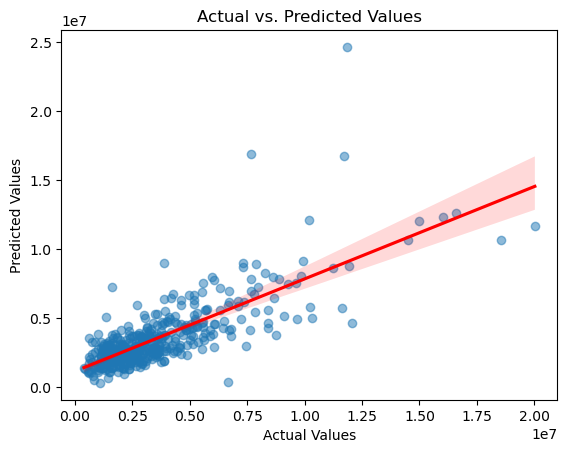

In [24]:
linear_model.fit(X_train_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Linear Regression PCA

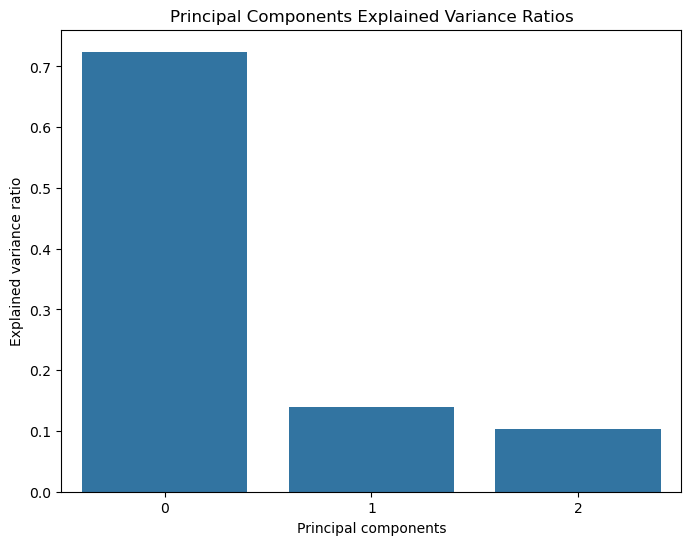

                             PC 1      PC 2      PC 3
public_insurance         0.934236  0.050943 -0.349408
public_insurance_ratio   0.353822 -0.230621  0.904786
migrant_patients         0.032832  0.959135  0.234880
lep_patients             0.010297  0.026580 -0.011912
total_other_revenue      0.009635  0.009569 -0.022818
hispanic_any_race        0.008352  0.037226 -0.006707
total_sfs                0.008086  0.013749 -0.013140
uninsured                0.007470  0.016198 -0.009659
homeless_patients        0.007000  0.012077 -0.017458
public_housing_patients  0.006774  0.003820 -0.014520
low_income               0.006462  0.023876 -0.007983
total_grant_funding      0.006151  0.008362 -0.011526
total_patients           0.006102  0.019742 -0.008722
total_18_up              0.006033  0.019044 -0.009425
total_0_17               0.005639  0.019219 -0.006413


In [25]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_ir)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ir)
X_test_pca = pca.transform(X_test_ir)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_ir.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [26]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_train_ir.index)
X_train_pca_ir = pd.concat([X_train_ir, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_test_ir.index)
X_test_pca_ir = pd.concat([X_test_ir, X_test_pca_df], axis=1)


R2 Score: 0.5767641346251029, Root Mean Squared Error: 1824588.6244508885, Mean Absolute Error: 1209901.731707317


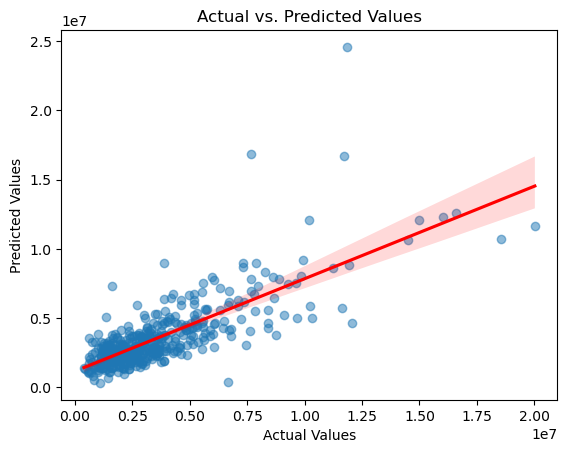

In [27]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ir, X_test_pca_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

R2 Score: 0.5777073472998792, Root Mean Squared Error: 1821154.6120145547, Mean Absolute Error: 1208305.044813875


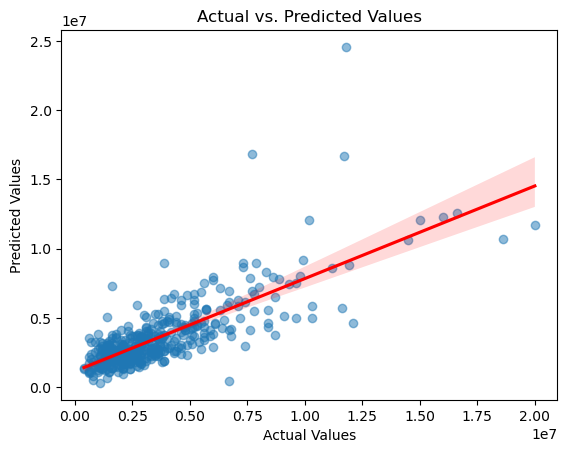

In [28]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ir, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## IV. Imputed & Power Transformed Data

### A. Linear Regression

In [29]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.6047513525355097, 0.06947070981281438),
 'neg_mean_squared_error': (-2855610374306.5996, 634798226308.4662),
 'neg_mean_absolute_error': (-1196808.4508301315, 99042.38202648143)}

R2 Score: 0.6192870975485072, Root Mean Squared Error: 1730503.6874777544, Mean Absolute Error: 1225567.4671308757


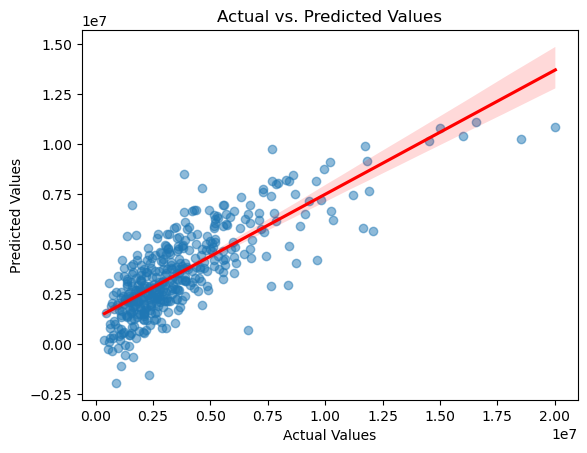

In [30]:
linear_model.fit(X_train_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Linear Regression PCA

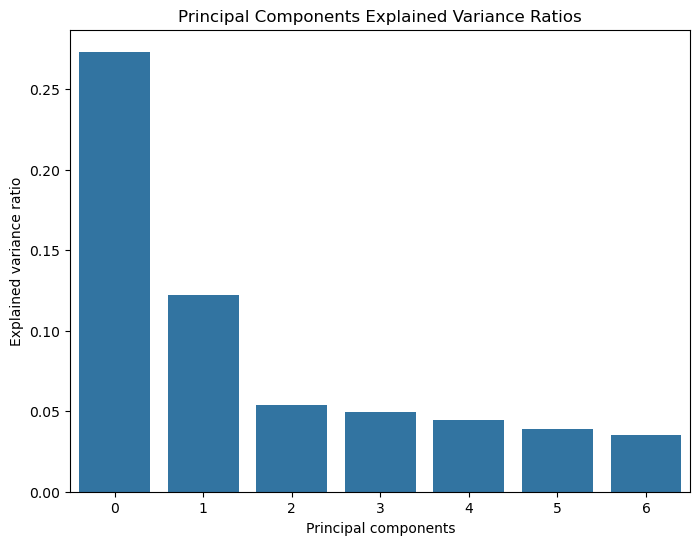

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_visits                 0.235272  0.049709 -0.012174  0.004798 -0.056684   
total_patients               0.235263  0.057500  0.010601 -0.001696 -0.084220   
total_18_up                  0.232604  0.063488 -0.001375  0.025379 -0.057197   
total_cost_care              0.229821  0.047524 -0.037124 -0.016406 -0.011643   
medicaid                     0.222103  0.025255 -0.058681 -0.040705 -0.087287   
low_income                   0.214458 -0.057850  0.003383  0.128714 -0.118506   
total_0_17                   0.211451  0.053887  0.058484 -0.062778 -0.141373   
total_grant_funding          0.199849 -0.027455 -0.023091 -0.058352  0.003786   
hispanic_any_race            0.199768 -0.111107  0.153363 -0.083465  0.061417   
TotalWeeklyHoursOfOperation  0.194158  0.074009 -0.030053  0.130188 -0.045191   
uninsured                    0.192548 -0.082500  0.115419  0.034778  0.005082   
lep_patients                

In [31]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_ip)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ip)
X_test_pca = pca.transform(X_test_ip)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_ip.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [32]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_ip.index)
X_train_pca_ip = pd.concat([X_train_ip, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_ip.index)

X_test_pca_ip = pd.concat([X_test_ip, X_test_pca_df], axis=1)



R2 Score: 0.6226760506005656, Root Mean Squared Error: 1722784.3467407478, Mean Absolute Error: 1237220.0382051268


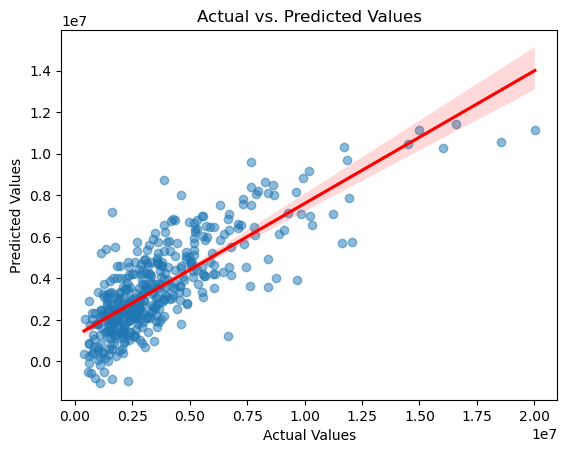

In [33]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ip, X_test_pca_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [34]:
add_model_score('Linear Regression', 'imputed_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

R2 Score: 0.6191614682044007, Root Mean Squared Error: 1729459.898760503, Mean Absolute Error: 1225590.2836197664


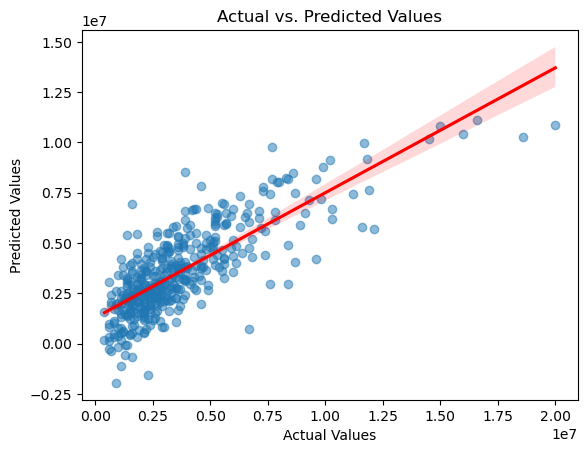

In [35]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ip, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

# Scores Analysis

In [36]:
model_scores.sort_values('score_r2_test',ascending=False)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
5,Linear Regression,reduced_power_rounded,False,1.558890e+06,1.717171e+06,1.113463e+06,1.210513e+06,0.671297,0.624554,0.600767,0.067478,-2.886538e+12,6.224701e+11,-1.198890e+06,97918.261886,None
3,Linear Regression,reduced_power,False,1.558112e+06,1.718865e+06,1.111961e+06,1.210824e+06,0.671366,0.624391,0.600943,0.067920,-2.882800e+12,6.225083e+11,-1.197000e+06,99812.604036,None
10,Linear Regression,imputed_power,True,1.562224e+06,1.722784e+06,1.133349e+06,1.237220e+06,0.669629,0.622676,0.604751,0.069471,-2.855610e+12,6.347982e+11,-1.196808e+06,99042.382026,None
9,Linear Regression,imputed_power,False,1.548838e+06,1.730504e+06,1.113844e+06,1.225567e+06,0.675267,0.619287,0.604751,0.069471,-2.855610e+12,6.347982e+11,-1.196808e+06,99042.382026,None
11,Linear Regression,imputed_power_rounded,False,1.549464e+06,1.729460e+06,1.115457e+06,1.225590e+06,0.675260,0.619161,0.604739,0.068872,-2.858099e+12,6.340952e+11,-1.198126e+06,97479.877286,None
4,Linear Regression,reduced_power,True,1.571280e+06,1.737409e+06,1.123194e+06,1.220351e+06,0.665788,0.616243,0.600943,0.067920,-2.882800e+12,6.225083e+11,-1.197000e+06,99812.604036,None
8,Linear Regression,imputed_robust_rounded,False,1.454806e+06,1.821155e+06,1.014207e+06,1.208305e+06,0.713726,0.577707,0.474214,0.145993,-3.674495e+12,7.212970e+11,-1.202511e+06,71968.654442,None
7,Linear Regression,imputed_robust,True,1.453429e+06,1.824589e+06,1.014008e+06,1.209902e+06,0.714042,0.576764,0.476564,0.144376,-3.658321e+12,7.190376e+11,-1.200728e+06,72213.913958,None
6,Linear Regression,imputed_robust,False,1.453308e+06,1.825113e+06,1.013904e+06,1.209878e+06,0.714089,0.576521,0.476564,0.144376,-3.658321e+12,7.190376e+11,-1.200728e+06,72213.913958,None
2,Linear Regression,reduced_robust_rounded,False,1.476525e+06,1.851220e+06,1.033305e+06,1.212244e+06,0.705114,0.563649,0.465122,0.131278,-3.765382e+12,6.703328e+11,-1.212331e+06,76012.425916,None


# Ensemble Models

## I. Reduced & Robust Scaled Data

##### Importing Data

### C. Random Forest Regression

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rr, y_train)

y_pred = rf_gridsearch.predict(X_test_rr)
print(rf_gridsearch.score(X_test_rr, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6589158179277415
Best parameters: {'criterion': 'squared_error', 'max_depth': None, 'max_features': 10, 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.6746417735125805, Root Mean Squared Error: 1599759.240433344, Mean Absolute Error: 1083272.0306341464


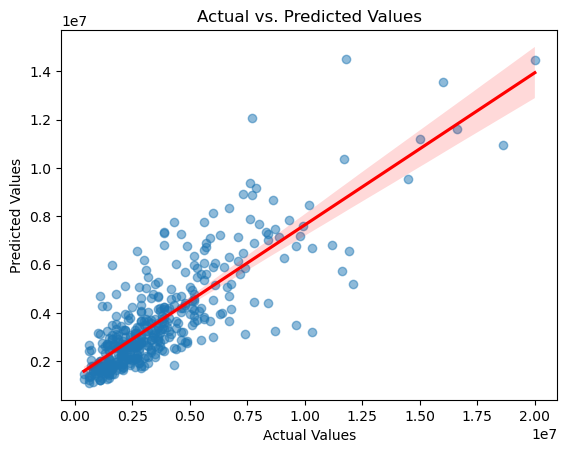

                             feature_importance
total_18_up                            0.103549
uninsured                              0.102268
total_patients                         0.098317
TotalWeeklyHoursOfOperation            0.072774
medicaid                               0.056336
low_income                             0.048885
total_0_17                             0.039738
total_sites                            0.033941
hispanic_any_race                      0.032858
diverse_patients_sum                   0.029611
total_grant_funding                    0.024690
lep_patients                           0.023332
homeless_patients                      0.021395
medicare_18_up                         0.019139
ZipCode_Count                          0.016041


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_28108/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [38]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### D. RandomForestRegressor with PCA

R2 Score: 0.6686933117354434, Root Mean Squared Error: 1614317.047426885, Mean Absolute Error: 1092699.267414634


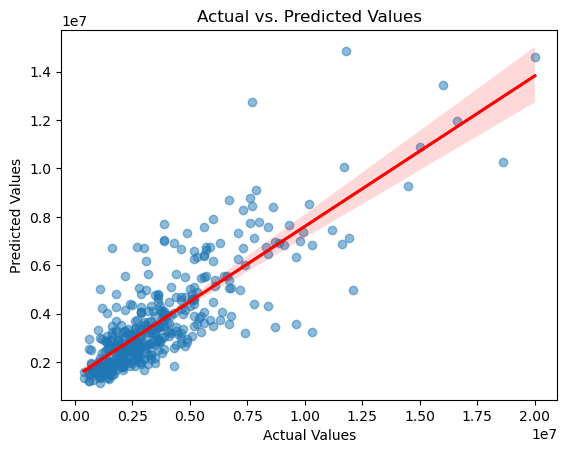

                             feature_importance
total_18_up                            0.100169
total_patients                         0.089910
TotalWeeklyHoursOfOperation            0.088185
uninsured                              0.077429
low_income                             0.056631
total_0_17                             0.055836
medicaid                               0.034778
total_grant_funding                    0.033789
hispanic_any_race                      0.030112
total_sites                            0.029106
PC 2                                   0.028936
lep_patients                           0.022757
diverse_patients_sum                   0.020582
fpl_unknown                            0.018666
medicare_18_up                         0.018441


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_28108/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [39]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6712161599532673, Root Mean Squared Error: 1606923.814728459, Mean Absolute Error: 1088492.6829268292


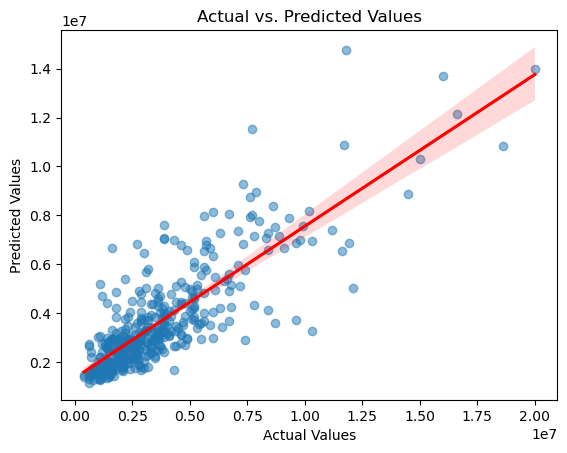

                             feature_importance
total_patients                         0.122407
total_18_up                            0.099060
uninsured                              0.082882
TotalWeeklyHoursOfOperation            0.067303
low_income                             0.054453
medicaid                               0.051704
total_0_17                             0.047587
hispanic_any_race                      0.038024
total_sites                            0.037237
diverse_patients_sum                   0.031408
total_grant_funding                    0.026699
homeless_patients                      0.022396
ZipCode_Count                          0.017463
SiteCity_Count                         0.014381
private_insurance                      0.014184


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_28108/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [40]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## II. Reduced & Power Transformed Data

##### Importing Data

### C. Random Forest Regressor with GridSearch

In [41]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rp, y_train)

y_pred = rf_gridsearch.predict(X_test_rp)
print(rf_gridsearch.score(X_test_rp, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6625439659328691
Best parameters: {'criterion': 'friedman_mse', 'max_depth': None, 'max_features': None, 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.6692231295881539, Root Mean Squared Error: 1613025.7420636714, Mean Absolute Error: 1104952.4801219513


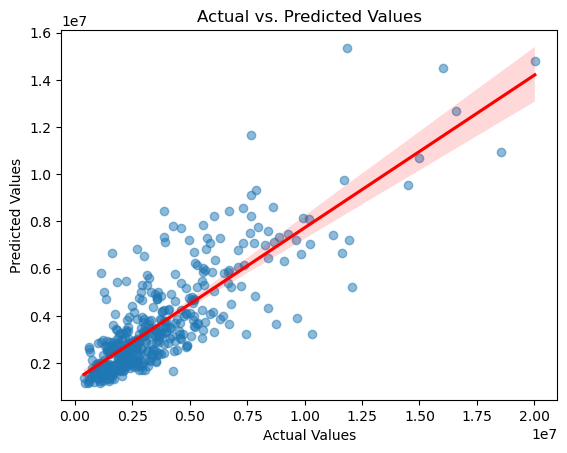

                             feature_importance
total_patients                         0.220495
total_18_up                            0.191272
uninsured                              0.115943
TotalWeeklyHoursOfOperation            0.051855
medicaid                               0.033486
low_income                             0.025405
total_sites                            0.024974
hispanic_any_race                      0.017742
diverse_patients_sum                   0.016297
diverse_race_proportion                0.015436
homeless_patients                      0.014287
total_other_revenue                    0.013307
SiteCity_Count                         0.012810
grants_to_rev_ratio                    0.012359
homeless_patients_ratio                0.011320


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_28108/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [42]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### D. RandomForestRegressor with PCA

R2 Score: 0.6508555587489369, Root Mean Squared Error: 1657205.2381245012, Mean Absolute Error: 1102561.4189268292


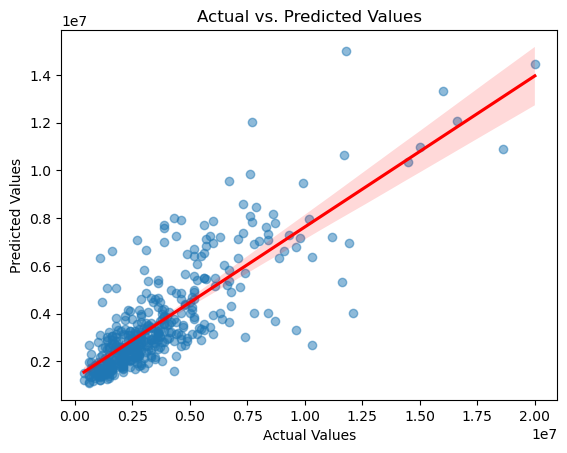

                             feature_importance
PC 1                                   0.535702
PC 7                                   0.037723
total_18_up                            0.031377
uninsured                              0.022753
TotalWeeklyHoursOfOperation            0.021361
medicaid                               0.019341
PC 4                                   0.016185
hispanic_any_race                      0.014847
diverse_patients_sum                   0.013954
total_patients                         0.013910
PC 3                                   0.012751
low_income                             0.012721
diverse_race_proportion                0.012149
total_sites                            0.011888
total_grant_funding                    0.011360


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_28108/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [43]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6568239909722635, Root Mean Squared Error: 1641717.8302456064, Mean Absolute Error: 1108019.512195122


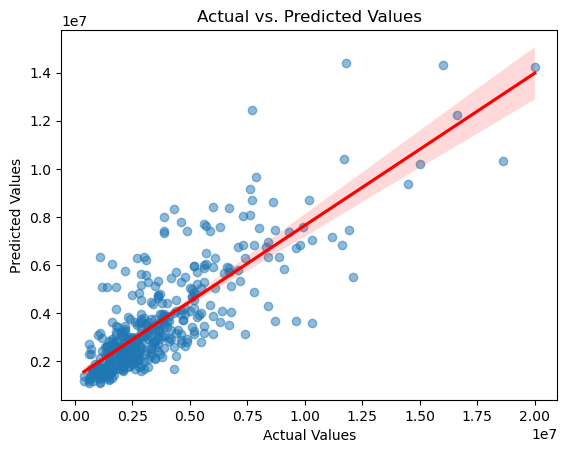

                             feature_importance
total_patients                         0.202755
total_18_up                            0.185599
uninsured                              0.126193
TotalWeeklyHoursOfOperation            0.053839
medicaid                               0.038242
hispanic_any_race                      0.026851
low_income                             0.023155
total_sites                            0.019633
diverse_patients_sum                   0.017123
grants_to_rev_ratio                    0.015292
diverse_race_proportion                0.014930
homeless_patients                      0.014580
total_other_revenue                    0.014245
migrant_patients                       0.012651
fpl_over_200                           0.011565


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_28108/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [44]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power_rounded', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## III. Imputed & Robust Scaled Data

##### Importing Data

### B. Random Forest Regressor

In [45]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_ir, y_train)

y_pred = rf_gridsearch.predict(X_test_ir)
print(rf_gridsearch.score(X_test_ir, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6698887185666804
Best parameters: {'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.6561643419302159, Root Mean Squared Error: 1644557.9758014192, Mean Absolute Error: 1103944.6127560977


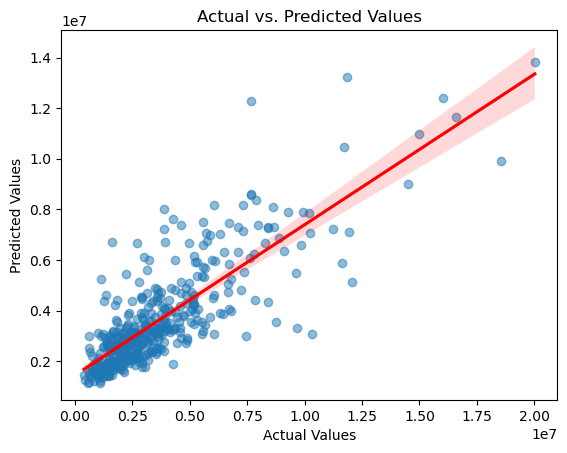

                             feature_importance
total_patients                         0.090266
total_18_up                            0.075319
uninsured                              0.068685
total_visits                           0.057120
total_cost_care                        0.053798
low_income                             0.048910
TotalWeeklyHoursOfOperation            0.045282
total_sites                            0.042397
total_0_17                             0.042034
medicaid                               0.040275
total_grant_funding                    0.023689
total_sfs                              0.023621
diverse_patients_sum                   0.019871
lep_patients                           0.018499
homeless_patients                      0.017814


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_28108/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [46]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6762977319972849, Root Mean Squared Error: 1594457.4220504314, Mean Absolute Error: 1093280.487804878


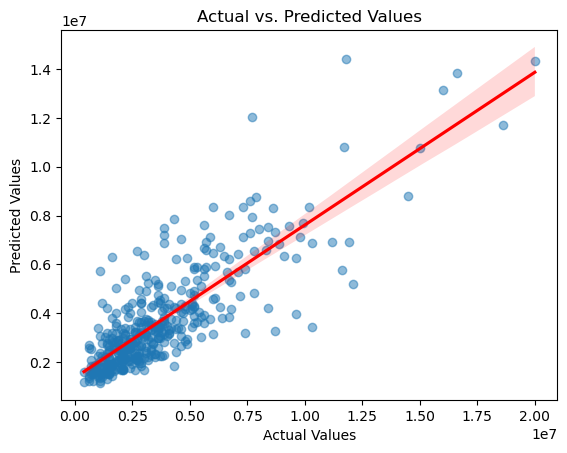

                             feature_importance
uninsured                              0.084315
TotalWeeklyHoursOfOperation            0.072547
total_patients                         0.066878
total_18_up                            0.065342
total_visits                           0.058155
total_cost_care                        0.040910
medicaid                               0.040104
low_income                             0.039619
total_0_17                             0.033847
hispanic_any_race                      0.031918
total_sites                            0.030318
diverse_patients_sum                   0.029129
total_sfs                              0.026597
total_grant_funding                    0.025350
lep_patients                           0.020847


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_28108/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [47]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## IV. Imputed & Power Transformed Data

##### Importing Data

### B. Random Forest Regressor

In [48]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, scoring='r2', cv=kf)

rf_gridsearch.fit(X_train_ip, y_train)

y_pred = rf_gridsearch.predict(X_test_ip)
print(rf_gridsearch.score(X_test_ip, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6748017346864559
Best parameters: {'criterion': 'squared_error', 'max_depth': None, 'max_features': 10, 'n_estimators': 200, 'n_jobs': -1}


R2 Score: 0.5438389960648649, Root Mean Squared Error: 1894230.4306716993, Mean Absolute Error: 1184663.29652439


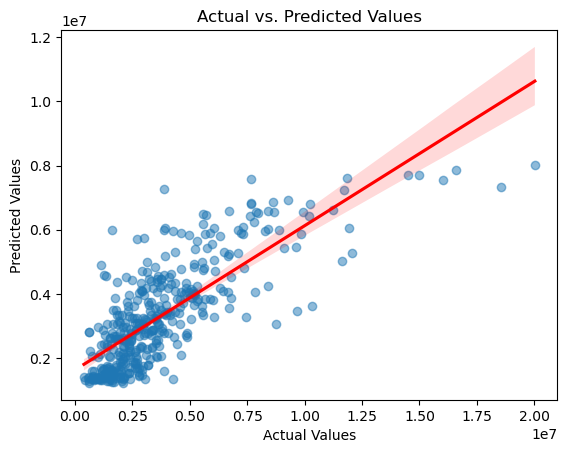

                             feature_importance
total_18_up                            0.101960
total_patients                         0.094293
uninsured                              0.087285
total_visits                           0.069449
TotalWeeklyHoursOfOperation            0.048609
low_income                             0.047133
total_cost_care                        0.043764
medicaid                               0.033301
total_sites                            0.033114
hispanic_any_race                      0.029364
total_0_17                             0.027239
total_sfs                              0.022811
diverse_patients_sum                   0.020796
total_grant_funding                    0.018633
homeless_patients                      0.015366


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_28108/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [49]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.5365493591901003, Root Mean Squared Error: 1907839.3357663956, Mean Absolute Error: 1171784.1463414633


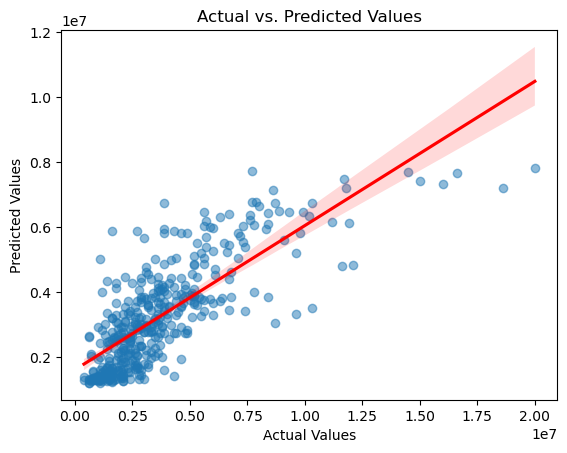

                             feature_importance
total_patients                         0.093408
total_18_up                            0.086999
uninsured                              0.077577
total_visits                           0.076498
TotalWeeklyHoursOfOperation            0.056111
total_cost_care                        0.053336
low_income                             0.041561
total_sites                            0.037503
medicaid                               0.032857
total_sfs                              0.029297
total_0_17                             0.028187
diverse_patients_sum                   0.025477
hispanic_any_race                      0.024762
total_grant_funding                    0.017577
lep_patients                           0.016372


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_28108/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [50]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

# Scoring Summary

In [51]:
model_scores.sort_values('score_r2_test', ascending=False)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
19,Random Forest Regressor,imputed_robust_rounded,False,6.003091e+05,1.594457e+06,4.001956e+05,1.093280e+06,0.951256,0.676298,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
12,Random Forest Regressor,reduced_robust,False,5.936710e+05,1.599759e+06,3.997744e+05,1.083272e+06,0.952290,0.674642,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
14,Random Forest Regressor,reduced_robust_rounded,False,6.271409e+05,1.606924e+06,4.090387e+05,1.088493e+06,0.946801,0.671216,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
15,Random Forest Regressor,reduced_power,False,6.222301e+05,1.613026e+06,4.139193e+05,1.104952e+06,0.947590,0.669223,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
13,Random Forest Regressor,reduced_robust,True,6.118625e+05,1.614317e+06,4.056139e+05,1.092699e+06,0.949322,0.668693,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
17,Random Forest Regressor,reduced_power_rounded,True,6.104415e+05,1.641718e+06,4.059257e+05,1.108020e+06,0.949597,0.656824,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
18,Random Forest Regressor,imputed_robust,False,6.178542e+05,1.644558e+06,4.104979e+05,1.103945e+06,0.948324,0.656164,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
16,Random Forest Regressor,reduced_power,True,6.206920e+05,1.657205e+06,4.078071e+05,1.102561e+06,0.947848,0.650856,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
5,Linear Regression,reduced_power_rounded,False,1.558890e+06,1.717171e+06,1.113463e+06,1.210513e+06,0.671297,0.624554,0.600767,0.067478,-2.886538e+12,6.224701e+11,-1.198890e+06,97918.261886,None
3,Linear Regression,reduced_power,False,1.558112e+06,1.718865e+06,1.111961e+06,1.210824e+06,0.671366,0.624391,0.600943,0.067920,-2.882800e+12,6.225083e+11,-1.197000e+06,99812.604036,None


In [52]:
best_forest = model_scores[model_scores['model_type'] == 'Random Forest Regressor']\
                .sort_values('score_r2_test', ascending=False).head(2)
best_linreg = model_scores[model_scores['model_type'] == 'Linear Regression']\
                .sort_values('score_r2_test', ascending=False).head(2)

top_models = pd.concat([best_forest, best_linreg], ignore_index=True)
top_models

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Random Forest Regressor,imputed_robust_rounded,False,6.003091e+05,1.594457e+06,4.001956e+05,1.093280e+06,0.951256,0.676298,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
1,Random Forest Regressor,reduced_robust,False,5.936710e+05,1.599759e+06,3.997744e+05,1.083272e+06,0.952290,0.674642,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
2,Linear Regression,reduced_power_rounded,False,1.558890e+06,1.717171e+06,1.113463e+06,1.210513e+06,0.671297,0.624554,0.600767,0.067478,-2.886538e+12,6.224701e+11,-1.198890e+06,97918.261886,None
3,Linear Regression,reduced_power,False,1.558112e+06,1.718865e+06,1.111961e+06,1.210824e+06,0.671366,0.624391,0.600943,0.067920,-2.882800e+12,6.225083e+11,-1.197000e+06,99812.604036,None


In [59]:
print(list(top_models[top_models['model_type'] == 'Random Forest Regressor']['best_params'].head(1)))

[{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}]


# Model Tuning

**Imputed Robust Rounded RF Model**

Best parameters: [{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}]


In [60]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

forest_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [80, 100, 120],  # Explore around the best found
    'max_depth': [None, 50, 100],    # Explore deeper trees and unrestricted
    'max_features': ['sqrt', 0.5, 'log2'],  # Include a fractional option
    'min_samples_split': [2, 4, 6],  # A bit more granularity around the best found
    'min_samples_leaf': [1, 2, 4],   # Investigate slightly larger leaves
    'criterion': ['friedman_mse', 'squared_error'],  # Include standard MSE for comparison
    'bootstrap': [True],             # Keep as is if no need to change
    'n_jobs': [-1],                  # Use all processors for speed
}

forest_gs = GridSearchCV(forest_model, param_grid=param_grid, cv=kf)

forest_gs.fit(X_train_ir, y_train)

y_pred = forest_gs.predict(X_test_ir)
print(forest_gs.score(X_test_ir, y_test))

best_params = forest_gs.best_params_
print("Best parameters:", best_params)

0.6749635561456012
Best parameters: {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 100, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80, 'n_jobs': -1}


R2 Score: 0.671011437398155, Root Mean Squared Error: 1608659.511889406, Mean Absolute Error: 1103047.348839704


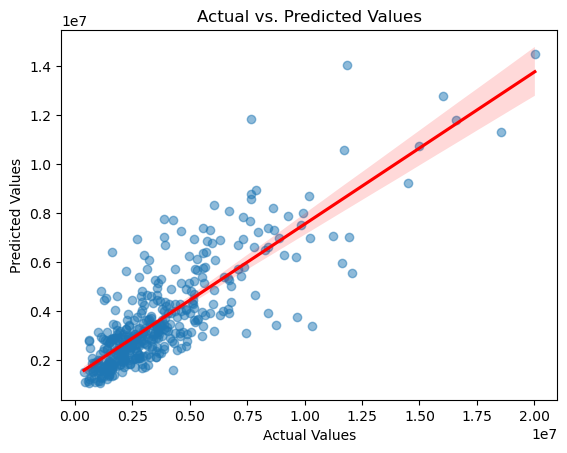

                             feature_importance
total_18_up                            0.164223
total_patients                         0.159279
uninsured                              0.083654
total_visits                           0.077617
TotalWeeklyHoursOfOperation            0.063255
medicaid                               0.029164
total_cost_care                        0.028096
low_income                             0.025699
total_sites                            0.022031
hispanic_any_race                      0.020535
diverse_patients_sum                   0.018869
homeless_patients                      0.017612
total_sfs                              0.014821
diverse_race_proportion                0.013365
SiteCity_Count                         0.011891


In [63]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

In [62]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

forest_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [80, 100, 120],  # Explore around the best found
    'max_depth': [None, 50, 100],    # Explore deeper trees and unrestricted
    'max_features': ['sqrt', 0.5, 'log2'],  # Include a fractional option
    'min_samples_split': [2, 4, 6],  # A bit more granularity around the best found
    'min_samples_leaf': [1, 2, 4],   # Investigate slightly larger leaves
    'criterion': ['friedman_mse', 'squared_error'],  # Include standard MSE for comparison
    'bootstrap': [True],             # Keep as is if no need to change
    'n_jobs': [-1],                  # Use all processors for speed
}

forest_gs = GridSearchCV(forest_model, param_grid=param_grid, cv=kf)

forest_gs.fit(X_train_ir, y_train_rounded)

y_pred = forest_gs.predict(X_test_ir)
print(forest_gs.score(X_test_ir, y_test_rounded))

best_params = forest_gs.best_params_
print("Best parameters:", best_params)

0.672635868590681
Best parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 50, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80, 'n_jobs': -1}


In [ ]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

In [71]:
X_train_rr_subset = pd.read_csv(DATA_PATH +'modeling/X_train_subset.csv')
X_test_rr_subset = pd.read_csv(DATA_PATH + 'modeling/X_test_subset.csv')
y_train_subset = pd.read_csv(DATA_PATH  +'modeling/y_train_subset.csv').values.ravel()
y_test_subset = pd.read_csv(DATA_PATH + 'modeling/y_test_subset.csv').values.ravel()

R2 Score: 0.5122354092773571, Root Mean Squared Error: 1096229.3429822712, Mean Absolute Error: 848275.0810122461


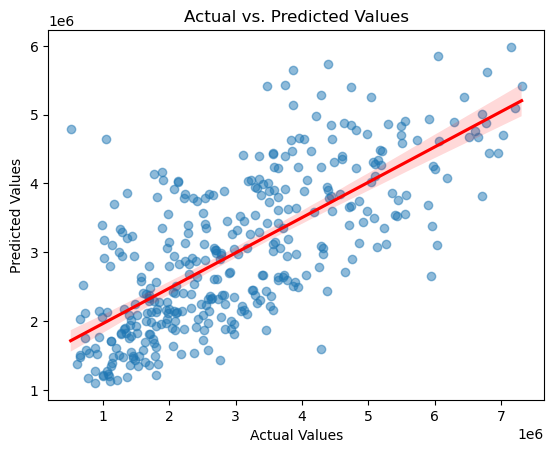

                             feature_importance
total_18_up                            0.213199
total_patients                         0.136267
low_income                             0.059508
TotalWeeklyHoursOfOperation            0.049214
uninsured                              0.039896
medicaid                               0.032157
migrant_patients                       0.024569
hispanic_any_race                      0.020722
total_0_17                             0.019595
homeless_patients                      0.018834
total_grant_funding                    0.018799
SiteCity_Count                         0.017718
diverse_patients_sum                   0.017434
diverse_race_proportion                0.017080
fpl_over_200                           0.017046


In [72]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr_subset, y_train_subset)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr_subset, X_test_rr_subset, y_train_subset, y_test_subset)

sns.regplot(x=y_test_subset.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr_subset.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

**Reduced Power Rounded and Reduced Power**